In [1]:
!pip3 install tensorflow==2.7.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

#set random
np_state = np.random.RandomState(2019)

2022-02-10 21:30:04.517612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 21:30:04.517635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filename = 'heart_failure_clinical_records_dataset.csv'

In [3]:
def bar_custom(current, total, width=100):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

#Don't think too much about the getDataset method. It is used for convenience
def getDataset(filename, **kwargs):
    url = f'https://github.com/IvanReznikov/mdx-msc-data-science/raw/main/datasets/{filename}'
    try:
        import os
        if filename not in os.listdir():
            !pip3 install wget
            import wget
            downloaded_filename = wget.download(url)
            print(f'{downloaded_filename} file downloaded', bar=bar_custom)
        else:
            print(f'{filename} already exists')
        return pd.read_csv(filename, **kwargs)
        
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

In [4]:
data = getDataset(filename)
data.head(5)

heart_failure_clinical_records_dataset.csv already exists


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**About the data:**

* age: Age of the patient
* anaemia: If the patient had the haemoglobin below the normal range
* creatinine_phosphokinase: The level of the creatine phosphokinase in the blood in mcg/L
* diabetes: If the patient was diabetic
* ejection_fraction: Ejection fraction is a measurement of how much blood the left ventricle pumps out with each contraction
* high_blood_pressure: If the patient had hypertension
* platelets: Platelet count of blood in kiloplatelets/mL
* serum_creatinine: The level of serum creatinine in the blood in mg/dL
* serum_sodium: The level of serum sodium in the blood in mEq/L
* sex: The sex of the patient
* smoking: If the patient smokes actively or ever did in past
* time: It is the time of the patient's follow-up visit for the disease in months
* DEATH_EVENT: If the patient deceased during the follow-up period

## Primary analysis

To examine the feature importance, let's draw a count plot of the target attribute and a correlation matrix of the various attributes.

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

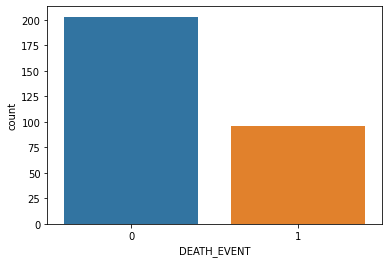

In [6]:
sns.countplot(x= data["DEATH_EVENT"])

Our target is imbalanced

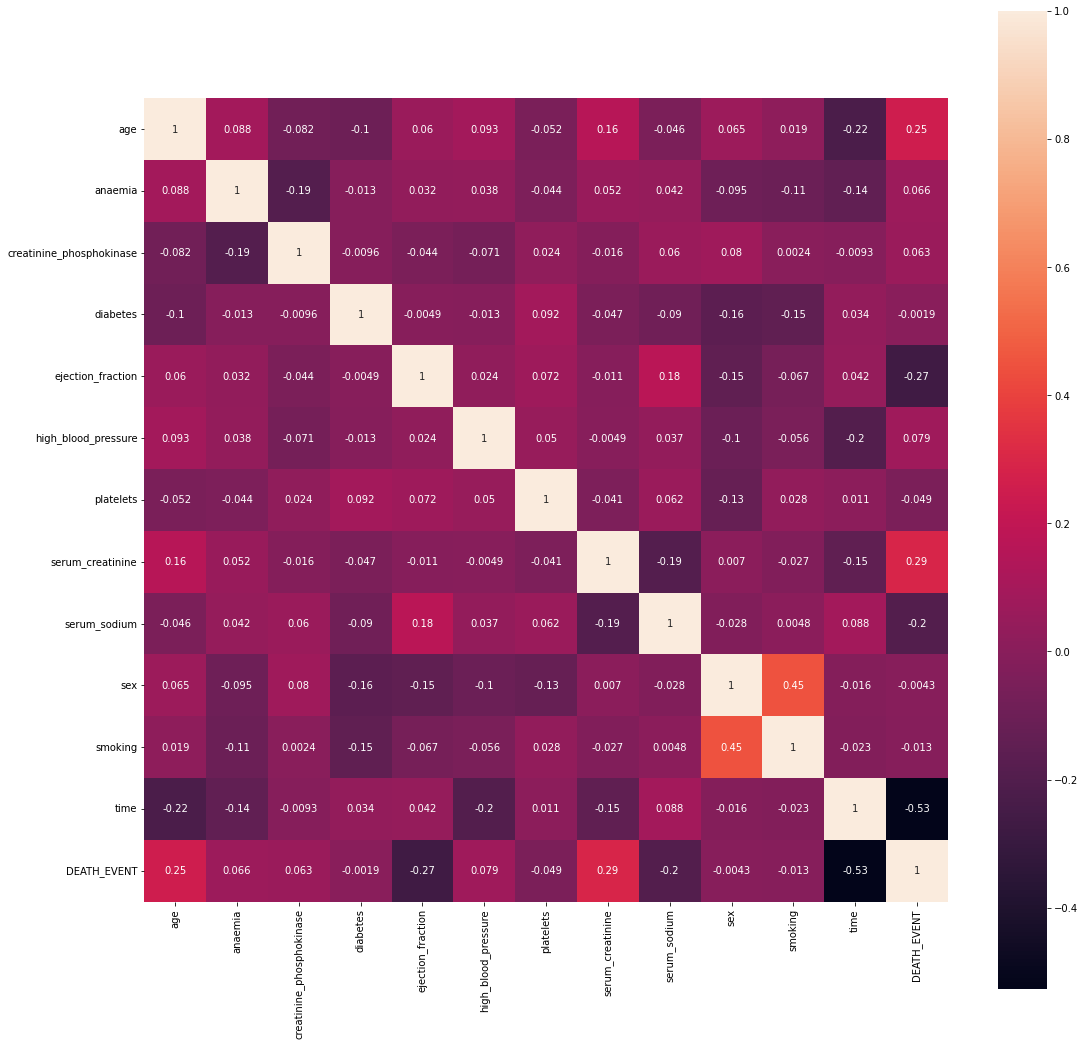

In [7]:
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,annot=True, square=True);

* Time of the patient's follow-up visit for the disease is crucial as initial diagnosis with cardiovascular issue and treatment reduces the chances of any fatality. It holds an inverse relation. 
* Second most crucial feature is ejection_fraction. It is quite expected as it is the efficiency of the heart.
* Age of the patient is the third most correlated feature. Clearly, as heart's functioning declines with aging 

In [8]:
data.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

Text(0.5, 1.0, 'Distribution Of Age')

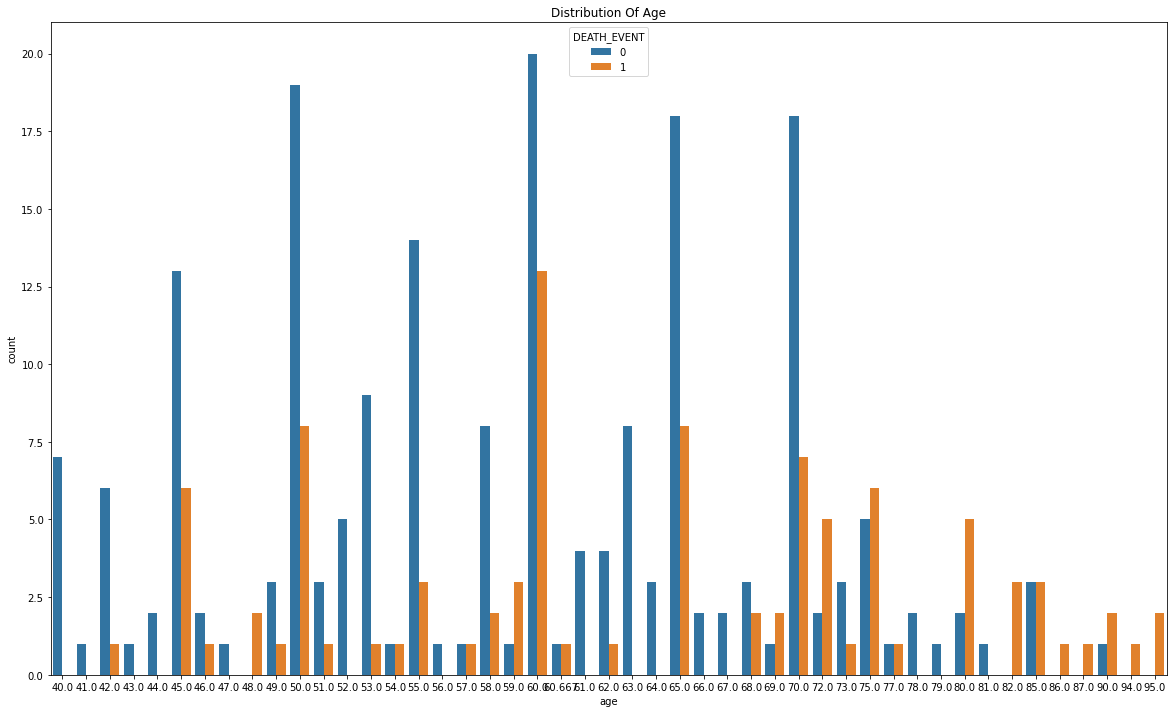

In [9]:
plt.figure(figsize=(20,12))
Days_of_week=sns.countplot(x=data['age'],data=data, hue ="DEATH_EVENT")
Days_of_week.set_title("Distribution Of Age")

A good option for visualization would be to use age binning.

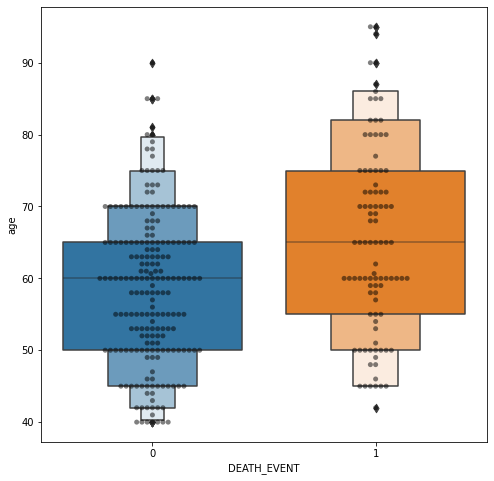

/home/ivan/.local/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


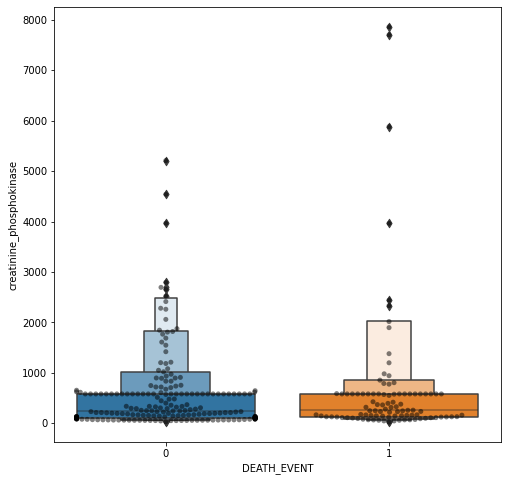

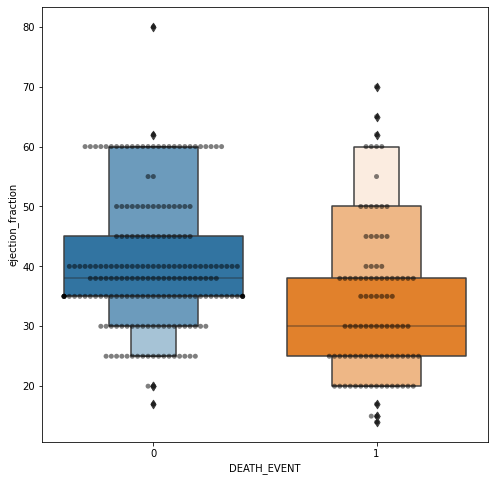

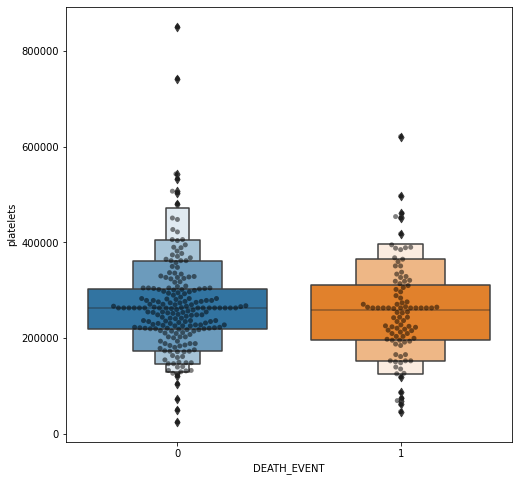

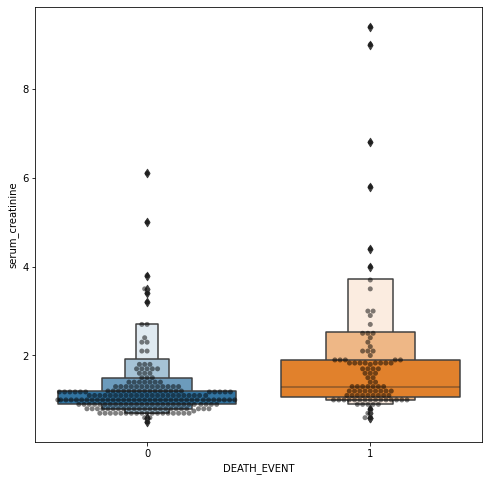

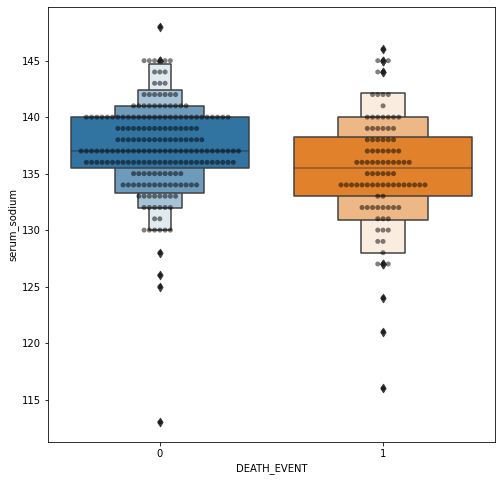

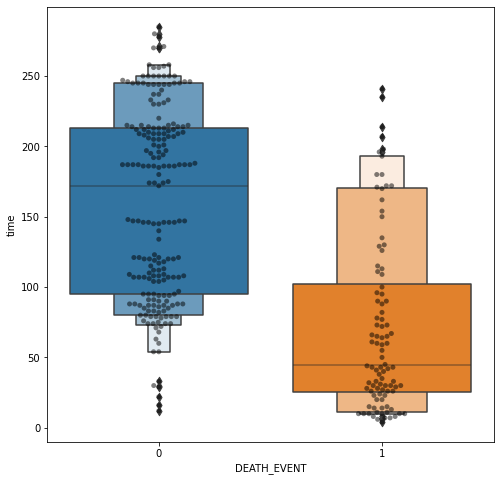

In [10]:
# Boxen and swarm plot of some non binary features.
feature = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium", "time"]
for i in feature:
    plt.figure(figsize=(8,8))
    sns.swarmplot(x=data["DEATH_EVENT"], y=data[i], color="black", alpha=0.5)
    sns.boxenplot(x=data["DEATH_EVENT"], y=data[i])
    plt.show()

There are outliers in our dataset. In the case of medical data, sometimes these outliers might be a source of valuable data. Let's not remove them for now.

<AxesSubplot:xlabel='time', ylabel='age'>

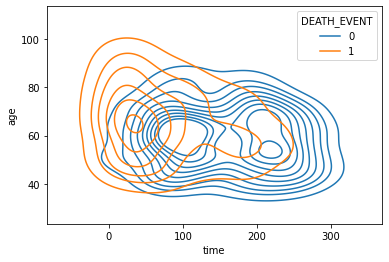

In [11]:
sns.kdeplot(x=data["time"], y=data["age"], hue =data["DEATH_EVENT"])

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


### Splitting data

In [13]:
#assigning values to features as X and target as y
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

As the feature values of our training dataset vary in different ranges, we'll perform the Standardization technique.

In [14]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,5.703353e-16,1.001676,-1.754448,-0.828124,-0.070223,0.771889,2.877170
anaemia,299.0,1.009969e-16,1.001676,-0.871105,-0.871105,-0.871105,1.147968,1.147968
creatinine_phosphokinase,299.0,0.000000e+00,1.001676,-0.576918,-0.480393,-0.342574,0.000166,7.514640
diabetes,299.0,9.060014e-17,1.001676,-0.847579,-0.847579,-0.847579,1.179830,1.179830
ejection_fraction,299.0,-3.267546e-17,1.001676,-2.038387,-0.684180,-0.007077,0.585389,3.547716
high_blood_pressure,299.0,0.000000e+00,1.001676,-0.735688,-0.735688,-0.735688,1.359272,1.359272
platelets,299.0,7.723291e-17,1.001676,-2.440155,-0.520870,-0.013908,0.411120,6.008180
serum_creatinine,299.0,1.425838e-16,1.001676,-0.865509,-0.478205,-0.284552,0.005926,7.752020
serum_sodium,299.0,-8.673849e-16,1.001676,-5.363206,-0.595996,0.085034,0.766064,2.582144
sex,299.0,-8.911489e-18,1.001676,-1.359272,-1.359272,0.735688,0.735688,0.735688


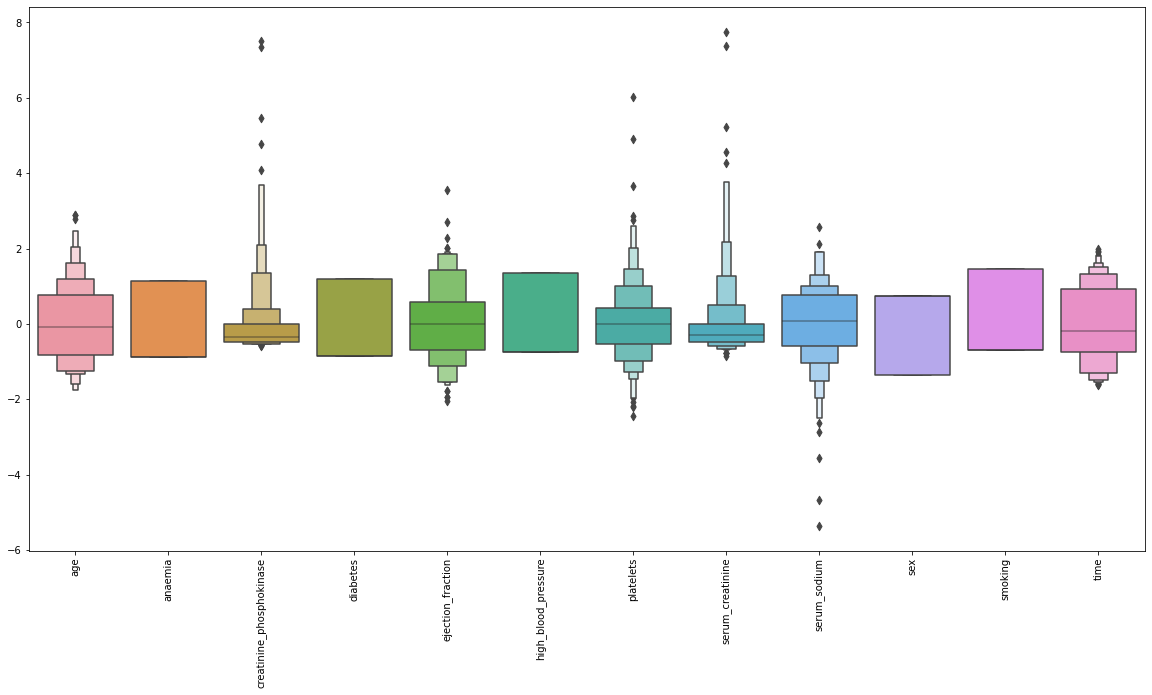

In [15]:
#looking at the scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df)
plt.xticks(rotation=90)
plt.show()

In [16]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

## Building Neural Network

Let's define early stopping conditions:
- min_delta: minimium amount of change to count as an improvement
- patience: number of epochs to wait before stopping
- epochs: number of epochs (defined @ model.fit)

In [17]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=20, 
    restore_best_weights=True)

In [18]:
X_train.shape

(224, 12)

In [34]:
from tensorflow.keras.optimizers import SGD
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
#model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 500, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
6/6 [==============================] - 0s 22ms/step - loss: 0.8925 - accuracy: 0.3520 - val_loss: 0.9042 - val_accuracy: 0.3333
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8869 - accuracy: 0.3520 - val_loss: 0.8983 - val_accuracy: 0.3333
Epoch 3/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8813 - accuracy: 0.3520 - val_loss: 0.8920 - val_accuracy: 0.3333
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8755 - accuracy: 0.3520 - val_loss: 0.8856 - val_accuracy: 0.3333
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8695 - accuracy: 0.3520 - val_loss: 0.8789 - val_accuracy: 0.3333
Epoch 6/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8625 - accuracy: 0.3520 - val_loss: 0.8719 - val_accuracy: 0.3333
Epoch 7/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8568 - accuracy: 0.3520 - val_loss: 0.8642 - val_accuracy: 0.3333
Epoch 8/500
6/6 [=========

6/6 [==============================] - 0s 6ms/step - loss: 0.4651 - accuracy: 0.7654 - val_loss: 0.4607 - val_accuracy: 0.8000
Epoch 60/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4170 - accuracy: 0.8212 - val_loss: 0.4611 - val_accuracy: 0.8000
Epoch 61/500
6/6 [==============================] - 0s 6ms/step - loss: 0.4497 - accuracy: 0.8101 - val_loss: 0.4604 - val_accuracy: 0.8000
Epoch 62/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4656 - accuracy: 0.7765 - val_loss: 0.4600 - val_accuracy: 0.8000
Epoch 63/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4318 - accuracy: 0.7877 - val_loss: 0.4600 - val_accuracy: 0.8000
Epoch 64/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4551 - accuracy: 0.7821 - val_loss: 0.4615 - val_accuracy: 0.8000
Epoch 65/500
6/6 [==============================] - 0s 7ms/step - loss: 0.4657 - accuracy: 0.7654 - val_loss: 0.4627 - val_accuracy: 0.8000
Epoch 66/500
6/6 [===============

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 104       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
 dropout_6 (Dropout)         (None, 4)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [36]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 68.05%


### Analyzing training and validation loss over epochs

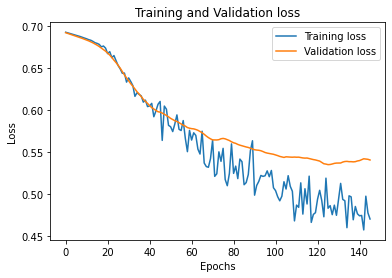

In [32]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

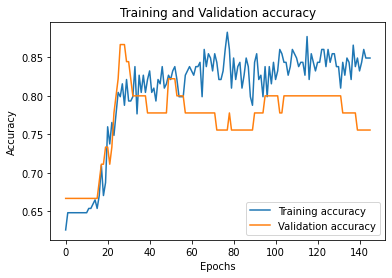

In [33]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Results

In [24]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

<AxesSubplot:>

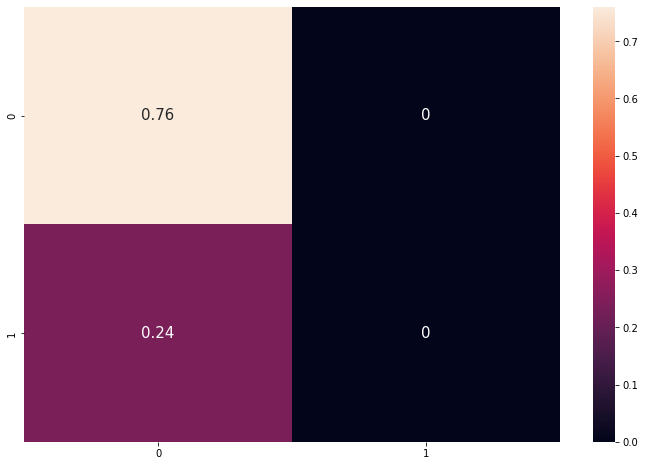

In [25]:
# confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15})

*What metric would've you chosen?*